Epoch 1/100
2288/2288 - 31s - 14ms/step - accuracy: 0.7447 - loss: 1.0663 - val_accuracy: 0.7916 - val_loss: 0.6848
Epoch 2/100
2288/2288 - 30s - 13ms/step - accuracy: 0.7943 - loss: 0.6834 - val_accuracy: 0.8199 - val_loss: 0.5903
Epoch 3/100
2288/2288 - 30s - 13ms/step - accuracy: 0.8094 - loss: 0.6156 - val_accuracy: 0.8260 - val_loss: 0.5519
Epoch 4/100
2288/2288 - 29s - 13ms/step - accuracy: 0.8173 - loss: 0.5782 - val_accuracy: 0.8358 - val_loss: 0.5187
Epoch 5/100
2288/2288 - 29s - 13ms/step - accuracy: 0.8235 - loss: 0.5529 - val_accuracy: 0.8410 - val_loss: 0.5019
Epoch 6/100
2288/2288 - 28s - 12ms/step - accuracy: 0.8291 - loss: 0.5320 - val_accuracy: 0.8433 - val_loss: 0.4857
Epoch 7/100
2288/2288 - 29s - 13ms/step - accuracy: 0.8328 - loss: 0.5165 - val_accuracy: 0.8485 - val_loss: 0.4727
Epoch 8/100
2288/2288 - 28s - 12ms/step - accuracy: 0.8366 - loss: 0.5027 - val_accuracy: 0.8487 - val_loss: 0.4620
Epoch 9/100
2288/2288 - 27s - 12ms/step - accuracy: 0.8390 - loss: 0.491

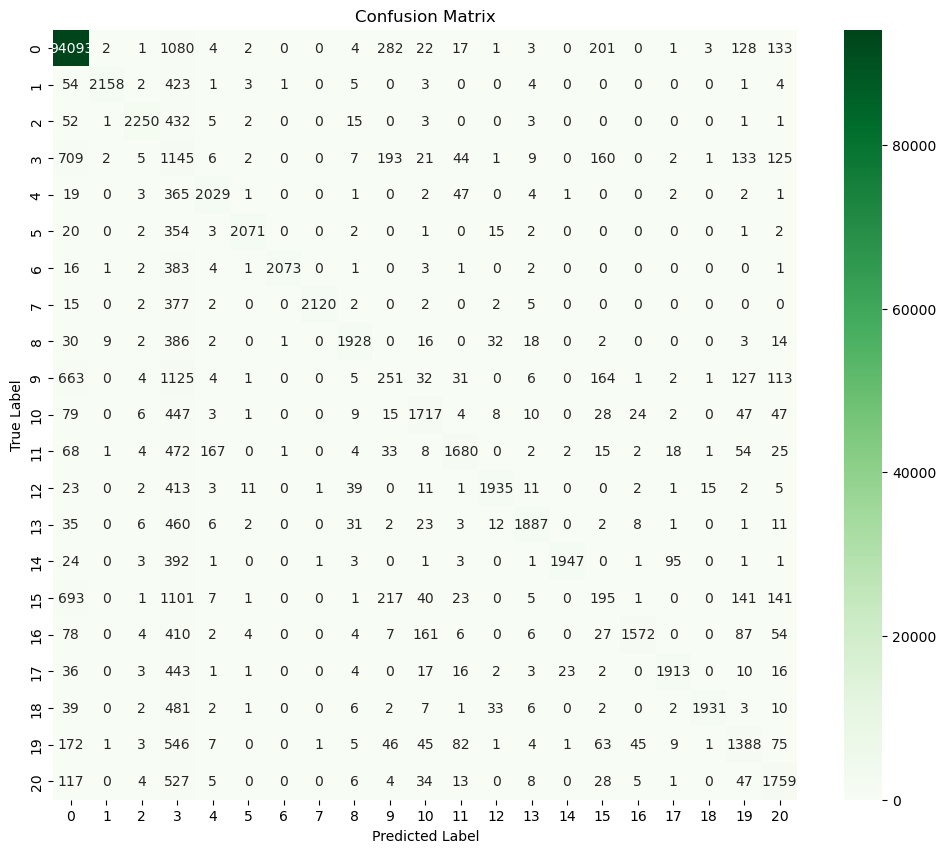

4576/4576 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


C:\Users\azwan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\azwan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


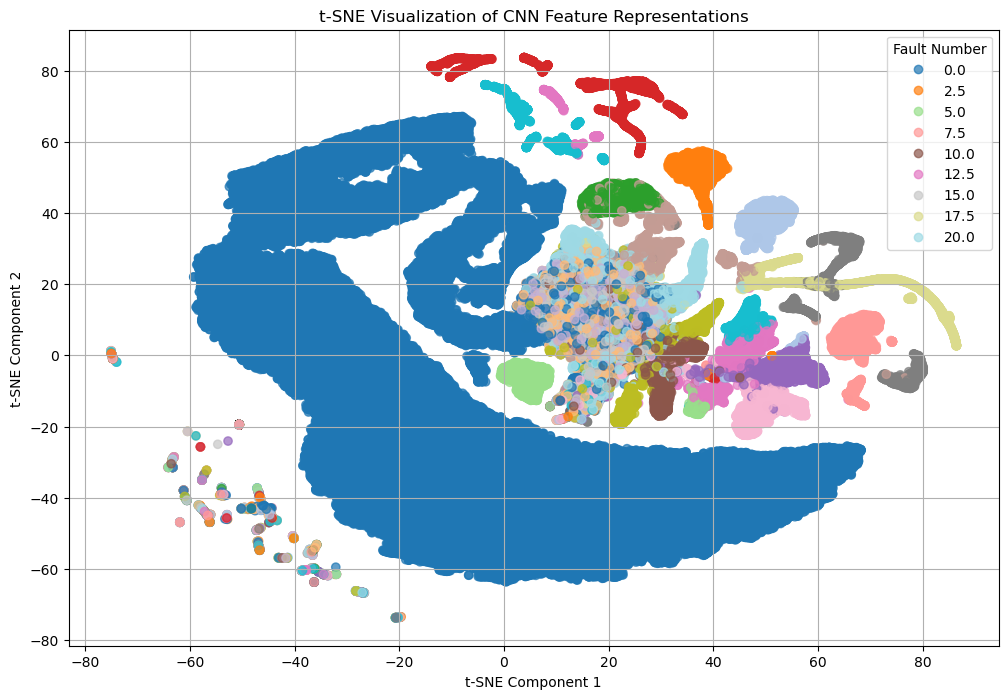

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --------------------------
# Load Data
# --------------------------
df_faulty_free = pd.read_csv('FaultFree_Testing.csv')
df_faulty_train = pd.read_csv('Faulty_Testing.csv')

df_faulty_free['faultNumber'] = 0
df_faulty_train['faultNumber'] = df_faulty_train['faultNumber'].fillna(-1)

df = pd.concat([df_faulty_free, df_faulty_train]).reset_index(drop=True)

X = df.drop(columns=['faultNumber']).values
y = df['faultNumber'].values

# --------------------------
# Normalize and reshape
# --------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# CNN Model
# --------------------------
def CNN_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(np.unique(y))
model = CNN_model((X_train.shape[1], 1), num_classes)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=2
)

# --------------------------
# Predictions and Metrics
# --------------------------
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test.astype(int)

# Confusion Matrix
labels = np.unique(y_true)
C = confusion_matrix(y_true, y_pred, labels=labels)

# Class-wise accuracy
class_wise_accuracy = C.diagonal() / C.sum(axis=1)
overall_accuracy = C.diagonal().sum() / C.sum()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nClass-Wise Accuracy:")
for label, acc in zip(labels, class_wise_accuracy):
    print(f"Fault {label}: {acc:.3f}")
print(f"Overall Accuracy: {overall_accuracy:.3f}")

# --------------------------
# Confusion Matrix Heatmap
# --------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(C, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --------------------------
# t-SNE Visualization
# --------------------------
# Extract features from the Flatten layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
features = feature_extractor.predict(X_test)

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_true, cmap='tab20', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Fault Number")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of CNN Feature Representations')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ===================== 1. Load Data =====================

df_faulty_free = pd.read_csv('FaultFree_Testing.csv')
df_faulty_train = pd.read_csv('Faulty_Testing.csv')

df_faulty_free['faultNumber'] = 0
df_faulty_train['faultNumber'] = df_faulty_train['faultNumber'].fillna(-1)

df = pd.concat([df_faulty_free, df_faulty_train]).reset_index(drop=True)

X = df.drop(columns=['faultNumber']).values
y = df['faultNumber'].values

# ===================== 2. Normalize & Reshape =====================

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===================== 3. Define CNN Model =====================

def CNN_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(inp)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(0.0001),
                  metrics=['accuracy'])
    return model

model = CNN_model(input_shape=(X_train.shape[1], 1), num_classes=len(np.unique(y)))

# ===================== 4. Train =====================

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# ===================== 5. Evaluate & Predict =====================

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test.astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# ===================== 6. Confusion Matrix =====================

labels = np.unique(y_true)
C = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(14, 10))
sns.heatmap(C, annot=True, fmt="d", cmap="viridis",
            linewidths=0.6, linecolor='black',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("Actual Class", fontsize=14)
plt.title("Confusion Matrix (Enhanced Visualization)", fontsize=16)
plt.tight_layout()
plt.show()

# ===================== 7. t-SNE Visualization =====================

X_flat = X.reshape(X.shape[0], X.shape[1])
tsne = TSNE(n_components=2, perplexity=35, learning_rate=250, n_iter=1200, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab20', s=18)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Projection of Process Samples by Fault Class")
plt.colorbar(scatter, label='Fault Class')
plt.show()
